In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import json
import os
from collections import Counter
import random
from scipy.stats import entropy

In [2]:
df = pd.read_csv('/Kaggle/data.csv')

In [45]:
df

,Time,Source,No.,Destination,Protocol,Length,Info
0,0.000000,192.167.8.166,1,192.167.255.255,NBNS,92,Name query NB WPAD<00>
1,0.784682,192.167.8.166,2,192.167.255.255,NBNS,92,Name query NB WPAD<00>
2,1.169060,VMware_8a:5c:e6,3,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
3,2.167949,VMware_8a:5c:e6,4,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
4,3.170095,VMware_8a:5c:e6,5,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
...,...,...,...,...,...,...,...
394131,1255.897236,192.167.7.162,394132,192.167.7.164,ICMP,98,"Echo (ping) request id=0x6592, seq=1177/39172..."
394132,1255.897921,192.167.7.164,394133,192.167.7.162,ICMP,98,"Echo (ping) reply id=0x6592, seq=1177/39172..."
394133,1255.993209,192.167.7.162,394134,142.250.190.97,TCP,74,[TCP Retransmission] [TCP Port numbers reused]...
394134,1256.921232,192.167.7.162,394135,192.167.7.164,ICMP,98,"Echo (ping) request id=0x6592, seq=1178/39428..."


In [4]:
df_clear = df.iloc[1000:]

In [46]:
Counter(list(df_clear['Source'])).most_common(20)

[('192.167.7.162', 115846),
 ('104.91.166.75', 57238),
 ('74.125.9.169', 37085),
 ('23.33.29.79', 25918),
 ('173.194.133.202', 22832),
 ('104.91.166.113', 18222),
 ('192.232.16.76', 15245),
 ('108.156.172.107', 10986),
 ('192.232.16.205', 8076),
 ('146.75.78.73', 6254),
 ('23.78.12.183', 5153),
 ('142.250.190.46', 4590),
 ('142.250.190.68', 4267),
 ('152.199.24.185', 3292),
 ('108.156.172.128', 3139),
 ('23.56.99.8', 2795),
 ('172.217.5.14', 2771),
 ('23.55.221.211', 2579),
 ('146.75.77.140', 2496),
 ('23.78.8.183', 2445)]

In [6]:
def make_unique(data):
    times = data['Time'].to_numpy()
    data = data[['Source', 'Destination', 'Protocol']]
    lst = list(map(tuple, data.values.tolist()))
    unique = {}
    new_values = []
    for line in lst:
        if line not in unique:
            unique[line] = len(unique)
        new_values.append(unique[line])
    return times, np.array(new_values)
time_series, values = make_unique(df_clear)

In [26]:
def cross_entropy(lst):
    """
    Считает кросс энтропию для дискретной случайной величины.
    На вход подаётся список из данных которые можно сравнить или список.
    """
    all_count = len(lst)
    tupled_lst = lst
    d = {}
    for t in tupled_lst:
        d[t] = 1 + d.get(t, 0)
    H = 0
    for keys in d.keys():
        p = d[keys] / all_count
        H += p * math.log(p)
    H0 = - H / math.log(all_count)
    return(H0)

def fem(times, lst, delta_time = 1, time_window = 100):
    values_dict = {}
    i, j = 0, 0
    actual_time = time_window + times[0]
    entropy_series = []
    
    if times[-1] < time_window:
        return np.array([cross_entropy(lst)])
    while times[j] < actual_time:
        values_dict[lst[j]] = 1 + values_dict.get(lst[j], 0)
        j += 1
    if i != j:
        entropy_series.append(cross_entropy(lst[i:j]))
    else:
        entropy_series.append(1.0)
    lens = []
    
    while j < len(times):
        while i < len(times) and times[i] < actual_time:
            if values_dict[lst[i]] == 1:
                del values_dict[lst[i]]
            else:
                values_dict[lst[i]] -= 1
            i += 1
        while j < len(times) and times[j] < actual_time + time_window:
            if values_dict.get(lst[j], 0) == 0:
                values_dict[lst[j]] = 1
            else:
                values_dict[lst[j]] += 1
            j += 1
        lens.append(j - i)
        
        p = []
        for key in values_dict.keys():
            if 0 == values_dict[key]:
                break
            p.append(values_dict[key] / (j - i))
        H0 = entropy(p) / math.log(j - i)
        entropy_series.append(H0)
        actual_time += delta_time
        
    return np.array(lens), np.array(entropy_series)

In [9]:
def save_arrays_to_file(filename, data):
    existing_data = {}
    
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            existing_data = json.load(file)
            existing_data = {tuple(map(float, key.strip('()').split(','))): value 
                            for key, value in existing_data.items()}
    
    for key, value in data.items():
        if key not in existing_data:
            existing_data[key] = value
    
    save_data = {str(key): value for key, value in existing_data.items()}
    
    with open(filename, 'w') as file:
        json.dump(save_data, file, indent=4)

def load_arrays_from_file(filename):
    try:
        with open(filename, 'r') as file:
            loaded_data = json.load(file)
            
        converted_data = {}
        for key_str, value in loaded_data.items():
            stripped_key = key_str.strip("()")
            a, b = map(float, stripped_key.split(","))
            converted_data[(a, b)] = np.array(value[1:])
        
        return converted_data
    
    except FileNotFoundError:
        return {}
    except json.JSONDecodeError:
        return {}

In [32]:
for dt in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 5]:
    for dw in tqdm([5, 10, 20, 50, 75, 100, 150, 200]):
        _, a = fem(time_series, values, delta_time = dt, time_window = dw)
        save_arrays_to_file('Series/s1000/series.json', {(dt, dw):list(a)})

100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


In [39]:
full_data = load_arrays_from_file('Series/s1000/series.json')

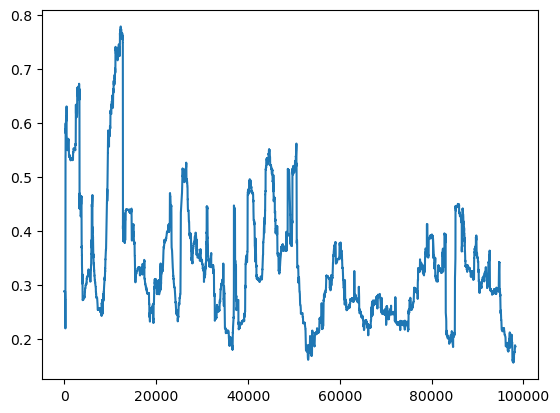

In [42]:
plt.plot(full_data[(0.01, 20)])

In [33]:
def add_ddos(df, attack_time = 150, window = 10, request_count = 30000, destination = '104.244.42.133', protocol = ['ICMP', 'DNS', 'TCP'], source_ip = '192.167'):
    times = []
    sources = []
    destinations = []
    protocols = []
    for _ in tqdm(range(request_count)):
        times.append(attack_time + (random.random() - 0.5) * window * 2)
        sources.append(source_ip + str(random.randint(1, 255)) + '.' + str(random.randint(1, 255)))
        destinations.append(destination)
        protocols.append(protocol[random.randint(0, len(protocol) - 1)])
    new_df = pd.DataFrame({'Time': times, 'Source': sources, 'Destination': destinations, 'Protocol': protocols})
    new_df = pd.concat([
        new_df,
        df]
    ).reset_index(drop=True)
    new_df = new_df.sort_values('Time').reset_index(drop=True)
    
    return new_df

def add_spoofing(df, attack_time = 500, window = 100, request_count = 50, destination = '192.167.7.162', source = '00:11:22:33:44:55'):
    times = []
    sources = []
    destinations = []
    protocols = []
    for i in tqdm(range(request_count)):
        times.append(attack_time + (random.random() - 0.5) * window * 2)
        sources.append(source)
        if i % 2 == 0:
            destinations.append(destination)
        else:
            destinations.append(destination[:-2] + '1')
        protocols.append('ARP')
    
    new_df = pd.DataFrame({'Time': times, 'Source': sources, 'Destination': destinations, 'Protocol': protocols})
    new_df = pd.concat([
        new_df,
        df]
    ).reset_index(drop=True)
    new_df = new_df.sort_values('Time').reset_index(drop=True)
    
    return new_df

def add_split(df, attack_start = 500, attack_end = 1000, delay = 1e-2, random_factor =2e-3, new_len = 10, attacker = '192.167.7.162'):
    new_df = df[df['Source'] != attacker][['Time', 'Source', 'Destination', 'Protocol']]
    df_attacker = df[df['Source'] == attacker]
    attacks = df_attacker.values.tolist()
    times = []
    sources = []
    destinations = []
    protocols = []
    for attack in attacks:
        if attack_end > attack[0] > attack_start:
            steps = attack[-2] // new_len
            for i in range(steps):
                times.append(attack[0] + delay * i + random.random() * random_factor)
                sources.append(attack[1])
                destinations.append(attack[2])
                protocols.append(attack[3])
    df_attacker = pd.DataFrame({'Time': times, 'Source': sources, 'Destination': destinations, 'Protocol': protocols})
    new_df = pd.concat([
        new_df,
        df_attacker]
    ).reset_index(drop=True)
    new_df = new_df.sort_values('Time').reset_index(drop=True)
    
    return new_df

In [34]:
dfddos = add_ddos(df_clear, attack_time = 1000, window = 50, request_count = 70000)
dfspoofed = add_spoofing(df_clear, attack_time = 1000, window = 100, request_count = 100)
dfdpi = add_split(df_clear, new_len = 30, attack_start = 900, attack_end = 1100, attacker = '192.232.16.76')

100%|██████████| 100/100 [00:00<?, ?it/s]


In [44]:
for data, name in zip([dfddos, dfspoofed, dfdpi], ['series_ddos', 'series_spoof', 'series_dpi']):
    time_series, values = make_unique(data)
    for dt in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 5]:
        for dw in tqdm([5, 10, 20, 50, 75, 100, 150, 200]):
            _, a = fem(time_series, values, delta_time = dt, time_window = dw)
            save_arrays_to_file('Series/s1000/' + name + '.json', {(dt, dw):list(a)})

100%|██████████| 8/8 [00:23<00:00,  2.91s/it]
